<a href="https://colab.research.google.com/github/karthikpuranik11/FIRE2021/blob/main/Malayalam/Bert%2BbiLSTM_Malayalam_transliterated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 32.2MB/s 
     |████████████████████████████████| 3.0MB 47.0MB/s 
     |████████████████████████████████| 901kB 39.8MB/s 
     |████████████████████████████████| 1.2MB 47.4MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train1=pd.read_csv('/content/mal_final.csv')
train1['labels']=LabelEncoder().fit_transform(train1['category'])
#train=train.drop(columns='label')
train1

,Unnamed: 0,Unnamed: 0.1,text,category,trans,translation,labels
0,0,0,Sunny chechi fans evide like adichu power kani...,unknown_state,{'ml': 'സുന്നി ചെച്ചി ഫാൻസ് എവിടെ ലൈക് അടിച്ച്...,"Sunny Cheung francs, 1992.",4
1,1,1,Angane july month ile ende aadyathe leave njan...,Positive,{'ml': 'അങ്ങനെ ജൂലൈ മോന്ത് എലി എന്ടെ ആദ്യത്തെ ...,"So, July, July 5th, July 5th, I'm on my first ...",2
2,2,2,ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...,unknown_state,{'ml': 'ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിര...,Those waiting for my brother's new show---,4
3,3,3,ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു..........,Positive,{'ml': 'ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്ന...,"Now, I'm going to begin the hunt of Laeddis......",2
4,4,4,Trailer powli oru raksha illa . Pakshea padam ...,Positive,{'ml': 'ട്രൈലർ പോളി ഒരു രക്ഷ ഇല്ല . പക്ഷീ പദം ...,The trilom system has no escape.,2
...,...,...,...,...,...,...,...
15883,15883,15883,Minimum 10 thavana kandavar maathram like adi,unknown_state,{'ml': 'മിനിമം 10 തവണ കണ്ടവർ മാത്രം ലൈക് അടി'},Only those who have seen 10 times have a license.,4
15884,15884,15884,Please cinema kaannaaan kothi aakunnu onnu rel...,Positive,{'ml': 'പ്ലീസ് സിനിമ കാണ്ണാൻ കൊത്തി ആകുന്നു ഒന...,"Please, let's just sign the film. Please.",2
15885,15885,15885,USA ok.. India No... Sadhacharam,unknown_state,{'ml': 'ഉഷ ഓക്.. ഇൻഡ്യ നോ... സദ്ചചരം'},Good-bye!,4
15886,15886,15886,nama hero december 12 wait & see mamamaga mah...,Positive,{'ml': 'നമഃ ഹീറോ ഡിസംബർ 12 വാറ്റ് & സീ മാമാമാ ...,The date of December 12 of the 12th Cygm 3 Cyg...,2


In [3]:
for i in range(len(train1)):
  train1['trans'][i]=train1['trans'][i][8:-2]
  if train1['category'][i]=='not-malayalam':
    train1['trans'][i]='NaN'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
train=pd.DataFrame(columns=['labels','tweets'])
train['labels']=train1['labels'].append(train1['labels'])
train['tweets']=train1['text'].append(train1['trans'])
train

,labels,tweets
0,4,Sunny chechi fans evide like adichu power kani...
1,2,Angane july month ile ende aadyathe leave njan...
2,4,ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...
3,2,ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു..........
4,2,Trailer powli oru raksha illa . Pakshea padam ...
...,...,...
15883,4,മിനിമം 10 തവണ കണ്ടവർ മാത്രം ലൈക് അടി
15884,2,പ്ലീസ് സിനിമ കാണ്ണാൻ കൊത്തി ആകുന്നു ഒന്ന് റിലീ...
15885,4,ഉഷ ഓക്.. ഇൻഡ്യ നോ... സദ്ചചരം
15886,2,നമഃ ഹീറോ ഡിസംബർ 12 വാറ്റ് & സീ മാമാമാ മഹാ മാഗ്...


In [5]:
train=train.dropna()

In [6]:
val=pd.read_csv('/content/Mal_sentiment_full_dev.tsv', sep="\t")
#val['tweet']=val['text']
#val=val.drop(columns=['Unnamed: 2','text'])
val['labels']=LabelEncoder().fit_transform(val['category'])
val['tweets']=val['text']
val=val.drop(columns=['category','text'])
val

,labels,tweets
0,2,Mammooka ninghal mass aa pwoli item
1,3,Waiting for Malayalam movie For Tamil paiyan
2,2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ...
3,2,#Trailer pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേ...
4,2,Mammoookkaaaa polichadukkiii katta waiting nv 21
...,...,...
1761,2,Aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ
1762,2,Katta katta katta katta waiting....cant wait man
1763,4,Arjun reddy bgm poole thonniyathu enniku mathr...
1764,2,Fahad ikka ithilum polikum en urappayi


In [7]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [8]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (31776, 2)
validation set size: (1766, 2)


In [9]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([3.43153348, 1.50954869, 0.49487619, 2.74641314, 0.60193218])

In [10]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [11]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [12]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [15]:
model = RFClassifier(5)
model = model.to(device)

In [16]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-uncased.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01 | Epoch Time: 12m 46s
Train Loss 1.0869578686725696 accuracy 0.5781722054380665
Val Loss 0.918816222676209 accuracy 0.6715741789354474

Epoch: 02 | Epoch Time: 12m 49s
Train Loss 0.7496933970386528 accuracy 0.7231243705941591
Val Loss 0.818209283053875 accuracy 0.6987542468856173

Epoch: 03 | Epoch Time: 12m 49s
Train Loss 0.607892009726944 accuracy 0.7826032225579054
Val Loss 0.8288864567875862 accuracy 0.7021517553793885

Epoch: 04 | Epoch Time: 12m 49s
Train Loss 0.49930196335728677 accuracy 0.8237034239677744
Val Loss 0.8575796186923981 accuracy 0.7202718006795017

Epoch: 05 | Epoch Time: 12m 49s
Train Loss 0.43300108072110655 accuracy 0.8491943605236657
Val Loss 0.8763707785734108 accuracy 0.7197055492638732



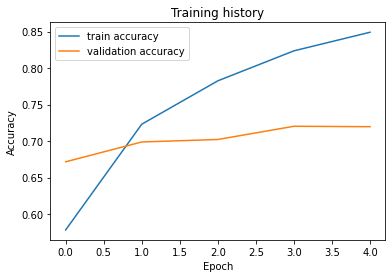

In [21]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [22]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.7197055492638732

In [23]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [24]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred,zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     0.3500    0.2059    0.2593       102
           1     0.5524    0.5781    0.5649       237
           2     0.7799    0.7932    0.7865       706
           3     0.8692    0.8014    0.8339       141
           4     0.7213    0.7586    0.7395       580

    accuracy                         0.7197      1766
   macro avg     0.6546    0.6274    0.6368      1766
weighted avg     0.7124    0.7197    0.7147      1766

